# 1. Импортируем необходимые библиотеки #

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from kaggle_environments import evaluate

# 2. Определяем агентов #

Опции для игры:
- 0 - камень;
- 1 - бумага;
- 2 - ножницы.

## 2.1. Агент, играющий всегда "камень" ##

In [2]:
%%writefile AGENTS\\rock_agent.py
def your_agent(observation, configuration):
    return 0

Writing AGENTS\\rock_agent.py


## 2.2. Агент, играющий всегда "бумага" ##

In [3]:
%%writefile AGENTS\\paper_agent.py
def your_agent(observation, configuration):
    return 1

Writing AGENTS\\paper_agent.py


## 2.3. Агент, играющий всегда "ножницы" ##

In [4]:
%%writefile AGENTS\\scissors_agent.py
def your_agent(observation, configuration):
    return 2

Writing AGENTS\\scissors_agent.py


## 2.4. Агент, копирующий предыдущее действие противника ##

In [5]:
%%writefile AGENTS\\copy_opponent_agent.py
import random

def copy_opponent(observation, configuration):
    
    # Случай, когда у нас есть информация о предыдущем действии противника
    if observation.step > 0:
        return observation.lastOpponentAction
    
    # При инициирующем шаге
    else:
        return random.randrange(0, configuration.signs)

Writing AGENTS\\copy_opponent_agent.py


## 2.5. Агент, который реагирует на последние действия противника ##

In [6]:
%%writefile AGENTS\\reactionary_agent.py
import random
import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Writing AGENTS\\reactionary_agent.py


## 2.6. Агент, который выбирает действие в зависимости от результатов последних ходов ##

In [7]:
%%writefile AGENTS\\counter_reactionary_agent.py
import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary_agent(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Writing AGENTS\\counter_reactionary_agent.py


## 2.7. Агент, который анализирует статистику ходов противника ##

In [8]:
%%writefile AGENTS\\statistical_agent.py
import random

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Writing AGENTS\\statistical_agent.py


# 3. Проводим турнир между агентами #

## 3.1. Определяем список агентов и пути к ним ##

In [9]:
agents_list = ["rock_agent", "paper_agent", "scissors_agent", "copy_opponent_agent", "reactionary_agent", "counter_reactionary_agent", "statistical_agent"]

base_directory = "AGENTS" # Директория, где хранятся агенты
agents_paths_list = [f"{base_directory}\\{agent_name}.py" for agent_name in agents_list] # Формируем список путей к агентам

## 3.2. Определяем матрицу результатов ##

In [10]:
agents_num = len(agents_list) # Определяем общее количество агентов

results = np.zeros((agents_num, agents_num)) # Инициализируем матрицу результатов игр нулями по горизонтали и вертикали

## 3.3. Инициируем турнир каждого агента против каждого ##

In [11]:
games_num = 100 # Количество игр в турнире
tournaments_num = 1 # Количество турниров

for i in range(agents_num):
    for j in range(i+1, agents_num):
        scores = evaluate(
        "rps", # Среда выполнения, нет необходимости изменять
        [agents_paths_list[i], agents_paths_list[j]], # Список сражающихся агентов
        configuration={"episodeSteps": games_num + 1}, # Количество игр в турнире
        num_episodes = tournaments_num # Количество турниров
        )

        # Сохраняем результаты игры в матрицу результатов игр
        results[i][j] = scores[0][0]
        results[j][i] = scores[0][1]

print("Турнир окончен!") # Выводим сообщение об окончании турнира по выходу из цикла

Турнир окончен!


# 4. Визуализируем результаты #

## 4.1. Строим датафрейм с заголовками строк и колонок ##

На пересечении строк и колонок отражен результат игр агента по строке против агента по столбцу.

In [12]:
results_df = pd.DataFrame(results, index=agents_list, columns=agents_list)
results_df

,rock_agent,paper_agent,scissors_agent,copy_opponent_agent,reactionary_agent,counter_reactionary_agent,statistical_agent
rock_agent,0.0,-100.0,100.0,0.0,-99.0,-50.0,-99.0
paper_agent,100.0,0.0,-100.0,0.0,-99.0,-49.0,-98.0
scissors_agent,-100.0,100.0,0.0,0.0,-98.0,-49.0,-100.0
copy_opponent_agent,0.0,0.0,0.0,0.0,100.0,98.0,-20.0
reactionary_agent,99.0,99.0,98.0,-100.0,0.0,-98.0,60.0
counter_reactionary_agent,50.0,49.0,49.0,-98.0,98.0,0.0,0.0
statistical_agent,99.0,98.0,100.0,20.0,-60.0,0.0,0.0


## 4.2. Строим матрицу корреляций ##

<Axes: >

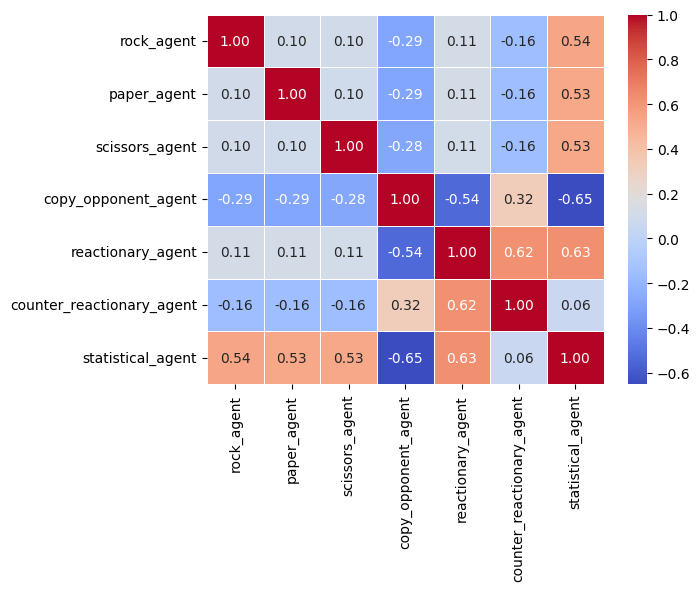

In [13]:
corr_matrix = results_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)